In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/sample_submission.csv
/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/train.csv
/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/test.csv


In [96]:
import polars as pl
import matplotlib.pyplot as plt

In [97]:
eg = pl.read_csv("/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/sample_submission.csv")

In [98]:
eg.head()

id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
str,f64,f64,f64,f64,f64
"""2024-09-03 23""",0.0,0.0,0.0,0.0,0.0
"""2024-09-04 00""",0.0,0.0,0.0,0.0,0.0
"""2024-09-04 01""",0.0,0.0,0.0,0.0,0.0
"""2024-09-04 02""",0.0,0.0,0.0,0.0,0.0
"""2024-09-04 03""",0.0,0.0,0.0,0.0,0.0


In [99]:
def get_df(df:str) -> pl.DataFrame:
    df = pl.read_csv(f"/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/{df}.csv")
    df = df.with_columns(
        (pl.col("id") + pl.lit(":00:00")).alias("full_date")
    )
    df = df.with_columns(
        pl.col("full_date").str.to_datetime()
    )
    df = df.with_columns(
        pl.col("full_date").dt.year().alias("year"),
        pl.col("full_date").dt.month().alias("month"),
        pl.col("full_date").dt.day().alias("day"),
        pl.col("full_date").dt.hour().alias("hour")
    )
    return df

In [100]:
df = pl.read_csv("/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/train.csv")

In [101]:
df = df.with_columns(
    (pl.col("id") + pl.lit(":00:00")).alias("full_date")    
)

In [102]:
df = df.with_columns(
    pl.col("full_date").str.to_datetime()
)

In [103]:
df = df.drop("id")

In [104]:
df = df.with_columns(
    pl.col("full_date").dt.year().alias("year"),
    pl.col("full_date").dt.month().alias("month"),
    pl.col("full_date").dt.day().alias("day"),
    pl.col("full_date").dt.hour().alias("hour")
)

In [105]:
df

valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,full_date,year,month,day,hour
f64,f64,f64,f64,f64,datetime[μs],i32,i8,i8,i8
42.9,0.718,15.7,73.1,64.4,2020-01-01 00:00:00,2020,1,1,0
33.6,0.587,10.1,74.8,66.0,2020-01-01 01:00:00,2020,1,1,1
29.3,null,5.1,51.0,44.9,2020-01-01 02:00:00,2020,1,1,2
30.5,0.246,7.2,27.7,25.1,2020-01-01 03:00:00,2020,1,1,3
29.3,0.204,8.3,15.3,13.6,2020-01-01 04:00:00,2020,1,1,4
…,…,…,…,…,…,…,…,…,…
null,0.222,55.1,12.0,5.3,2024-09-03 18:00:00,2024,9,3,18
null,0.245,48.2,13.4,7.0,2024-09-03 19:00:00,2024,9,3,19
null,0.234,44.5,12.4,7.1,2024-09-03 20:00:00,2024,9,3,20


In [106]:
gaz = ["NO2", "CO", "O3", "PM10", "PM25"]

In [107]:
# Conversion des colonnes Polars en listes ou Series pandas pour Matplotlib
dates = df["full_date"].to_list()
NO2 = df["valeur_NO2"].to_list()
CO = df["valeur_CO"].to_list()
O3 = df["valeur_O3"].to_list()
PM10 = df["valeur_PM10"].to_list()
PM25 = df["valeur_PM25"].to_list()

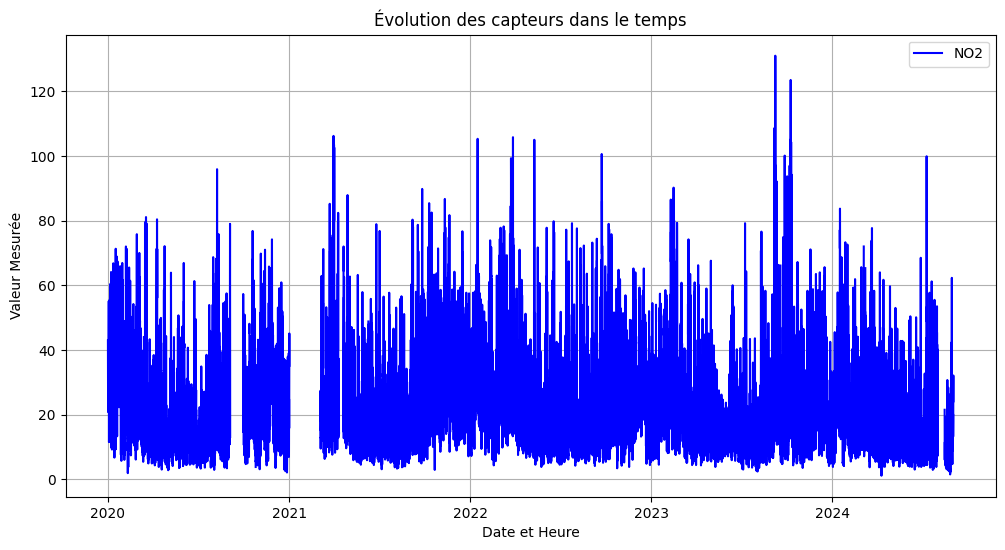

In [108]:
# Création du graphique
plt.figure(figsize=(12, 6)) # Définit la taille du graphique


plt.plot(dates, NO2, label="NO2", color="blue")

# Ajout de titres et d'étiquettes
plt.title("Évolution des capteurs dans le temps")
plt.xlabel("Date et Heure")
plt.ylabel("Valeur Mesurée")
plt.legend() # Affiche la légende (ex: "Capteur A", "Capteur B")
plt.grid(True) # Ajoute une grille pour une meilleure lisibilité

plt.show() # Affiche le graphique

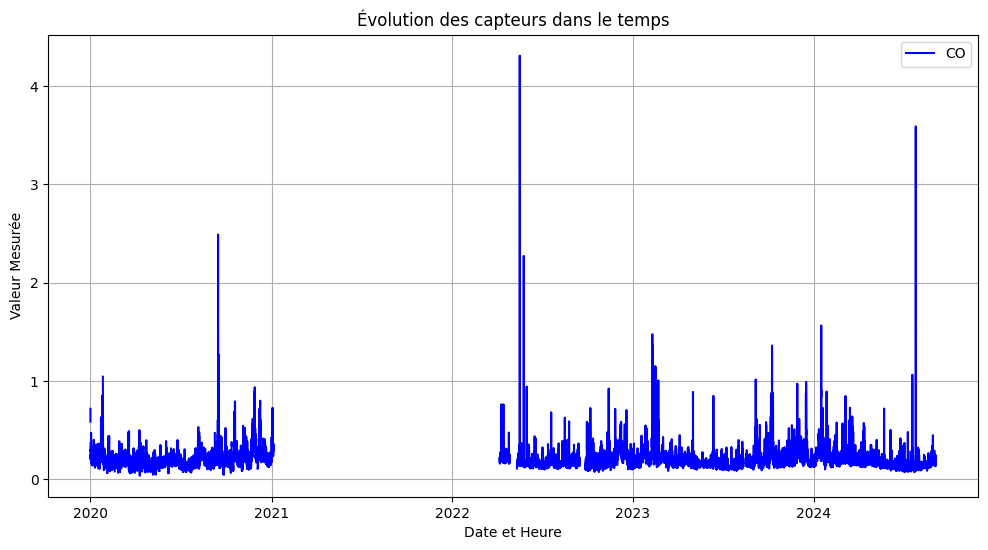

In [109]:
# Création du graphique
plt.figure(figsize=(12, 6)) # Définit la taille du graphique

plt.plot(dates, CO, label="CO", color="blue")

# Ajout de titres et d'étiquettes
plt.title("Évolution des capteurs dans le temps")
plt.xlabel("Date et Heure")
plt.ylabel("Valeur Mesurée")
plt.legend() # Affiche la légende (ex: "Capteur A", "Capteur B")
plt.grid(True) # Ajoute une grille pour une meilleure lisibilité

plt.show() # Affiche le graphique

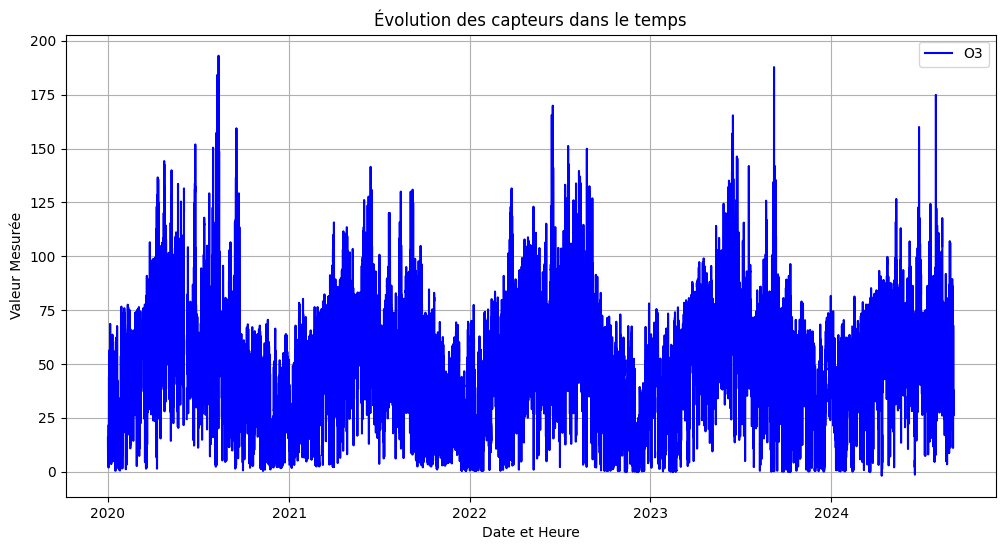

In [110]:
# Création du graphique
plt.figure(figsize=(12, 6)) # Définit la taille du graphique

plt.plot(dates, O3, label="O3", color="blue")

# Ajout de titres et d'étiquettes
plt.title("Évolution des capteurs dans le temps")
plt.xlabel("Date et Heure")
plt.ylabel("Valeur Mesurée")
plt.legend() # Affiche la légende (ex: "Capteur A", "Capteur B")
plt.grid(True) # Ajoute une grille pour une meilleure lisibilité

plt.show() # Affiche le graphique

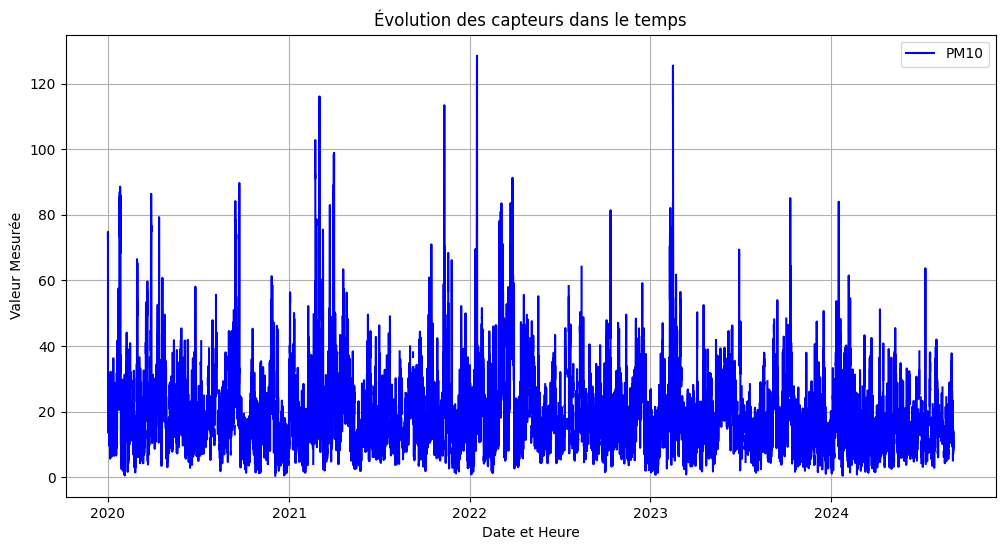

In [111]:
# Création du graphique
plt.figure(figsize=(12, 6)) # Définit la taille du graphique

plt.plot(dates, PM10, label="PM10", color="blue")

# Ajout de titres et d'étiquettes
plt.title("Évolution des capteurs dans le temps")
plt.xlabel("Date et Heure")
plt.ylabel("Valeur Mesurée")
plt.legend() # Affiche la légende (ex: "Capteur A", "Capteur B")
plt.grid(True) # Ajoute une grille pour une meilleure lisibilité

plt.show() # Affiche le graphique

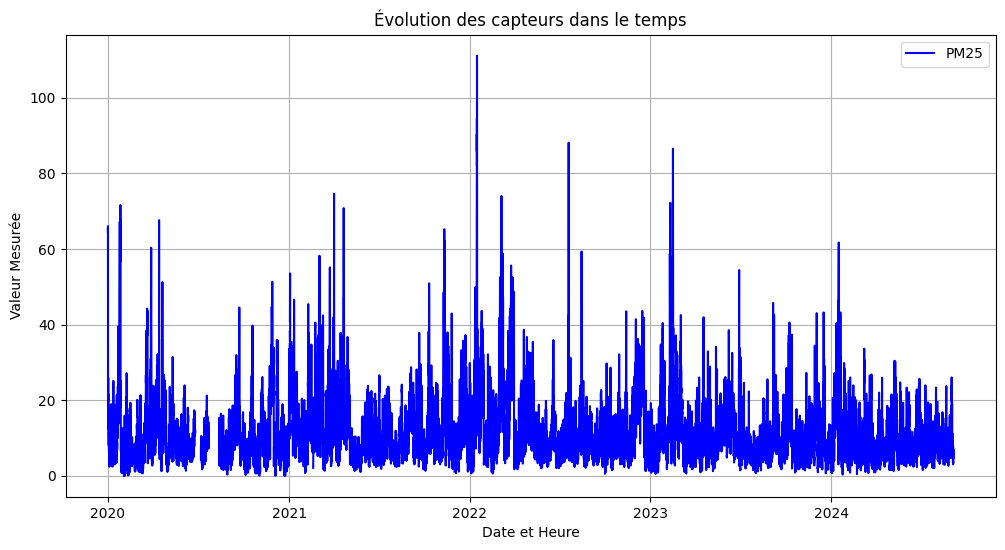

In [112]:
# Création du graphique
plt.figure(figsize=(12, 6)) # Définit la taille du graphique

plt.plot(dates, PM25, label="PM25", color="blue")

# Ajout de titres et d'étiquettes
plt.title("Évolution des capteurs dans le temps")
plt.xlabel("Date et Heure")
plt.ylabel("Valeur Mesurée")
plt.legend() # Affiche la légende (ex: "Capteur A", "Capteur B")
plt.grid(True) # Ajoute une grille pour une meilleure lisibilité

plt.show() # Affiche le graphique

In [113]:
train = df.filter(pl.col("full_date") < pl.date(year=2024, month=1, day=1))
out_of_time = df.filter(pl.col("full_date") > pl.date(year=2023, month=12, day=31))

In [114]:
val = pd.read_csv("/kaggle/input/x-hec-ts-2025-26-predicting-air-quality-in-paris/test.csv")

In [115]:
# The validation set (submission set) goes from 03/09/2024, 23h to 24/09/2024, 22h

In [116]:
# Baseline
# Option preferred : predict the mean for the specific day of the year
# Predict exact day like 01/01/2023 = mean(01/01/2021, 01/01/2022)

In [117]:
baseline_df = df.group_by("month", "day", "hour").agg(
    [
        pl.col("valeur_NO2").mean().alias("baseline_NO2"),
        pl.col("valeur_CO").mean().alias("baseline_CO"),
        pl.col("valeur_O3").mean().alias("baseline_O3"),
        pl.col("valeur_PM10").mean().alias("baseline_PM10"),
        pl.col("valeur_PM25").mean().alias("baseline_PM25")
    ]
)

In [118]:
baseline_df.head()

month,day,hour,baseline_NO2,baseline_CO,baseline_O3,baseline_PM10,baseline_PM25
i8,i8,i8,f64,f64,f64,f64,f64
12,7,6,42.2,0.454,5.55,18.8,15.85
12,1,2,16.25,0.265,30.2,18.8,16.375
10,6,14,14.925,0.172667,67.775,17.1,7.9
8,1,13,6.05,0.161,68.32,21.85,8.625
3,12,17,21.66,0.223,54.9,11.4,6.38


In [119]:
val = get_df("test")

In [120]:
final_predictions = val.join(
    baseline_df, 
    on=["month", "day", "hour"], # Les clés de jointure
    how="left"
)

In [121]:
final_predictions = final_predictions.drop(pl.col("full_date", "year", "month", "day", "hour"))

In [122]:
final_predictions = final_predictions.rename({
    "baseline_NO2" : "valeur_NO2",
    "baseline_CO" : "valeur_CO",
    "baseline_O3" : "valeur_O3",
    "baseline_PM10" : "valeur_PM10",
    "baseline_PM25" : "valeur_PM25"
})

In [ ]:
final_predictions = final_predictions.fill_null(0)

In [123]:
final_predictions.write_csv('submission.csv')

In [ ]:
# The baseline hits a score of 8.877

In [124]:
# After baseline : do reasearch, do we need to add specific features like day of the week etc